In [1]:
#combine all summary stats for one mouse
%load_ext autoreload
%autoreload 2
 
#%matplotlib inline

In [2]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

pdf_path = r'/Volumes\scratch\vr-foraging\sessions'
base_path = r'/Volumes/scratch/vr-foraging/data/'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/analysis_files'

from scipy.optimize import curve_fit

In [3]:
# #exploring at work
# session_path = r'/Volumes/scratch/vr-foraging/data/745305/745305_20240726T083719'

# #get mouse_id from first 6 numbers in file name
# mouse = session_path.split('/')[-1][:6]

# #get session from first 8 numbers after mouse_id
# session = session_path.split('/')[-1][6:15]

In [4]:
#exploring at home
session_path = r'/Users/nehal.ajmal/Desktop/717716_20240719T093806'
mouse = '717716'
session = '20240719T093806'

In [5]:
session_path = Path(session_path)
data = parse.load_session_data(session_path)

# Parse data into a dataframe with the main features
reward_sites, active_site, config = parse.parse_dataframe(data)

In [6]:
# Expand with extra columns
reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
 # Add extra columns to the active_site dataframe
active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

In [7]:
# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

In [8]:
# Load the encoder data separately
stream_data = parse.ContinuousData(data)
encoder_data = stream_data.encoder_data

# Plotting site duration


In [9]:
def plot_duration_by_site(data, x_col, y_col, hue_col, hue_order, palette, x_label, y_label, title, bbox_to_anchor=(1.05, 1), loc=2):
    """
    Plot duration of each reward site with the trial type / odor_label in color.

    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: The name of the column for the x-axis.
    - y_col: The name of the column for the y-axis.
    - hue_col: The name of the column for the hue.
    - hue_order: List of hue categories to order.
    - palette: Color palette for the plot.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title of the plot.
    - bbox_to_anchor: Position of the legend.
    - loc: Location of the legend.
    """
    fig, ax = plt.subplots()
    ax = sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue_col, hue_order=hue_order, ax=ax, palette=palette)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    plt.show()

In [10]:
# #add extra columns to active_site
# active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

# # reset the index to turn it into a column
# plot_df = active_site.reset_index()

# # shift the 'index' column by 1 position
# plot_df['next_site'] = plot_df['Seconds'].shift(-1)

# plot_df['time_spent'] = plot_df['next_site'] - plot_df['Seconds']
# plot_df = plot_df[plot_df['label'] == 'RewardSite']

In [11]:
active_site['next_intersite'] = active_site.index.to_series().shift(-1)
reward_sites = active_site.loc[active_site['label']=='RewardSite']
reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index

#make plot_df 
plot_df = reward_sites[['time_in_odor_site', 'odor_label', 'active_patch']]

In [12]:
plot_df

,time_in_odor_site,odor_label,active_patch
Seconds,,,
9.413737e+06,1.234016,ODOR_A,0.0
9.413744e+06,1.156000,ODOR_A,1.0
9.413755e+06,1.076000,NULL,2.0
9.413763e+06,1.016992,NULL,3.0
9.413768e+06,1.142016,ODOR_A,4.0
...,...,...,...
9.415799e+06,1.251008,NULL,111.0
9.415805e+06,1.235008,ODOR_A,112.0
9.415813e+06,1.293984,ODOR_A,113.0


In [13]:
# # #remove outlier
# plot_df = plot_df[plot_df['time_spent'] < 15]

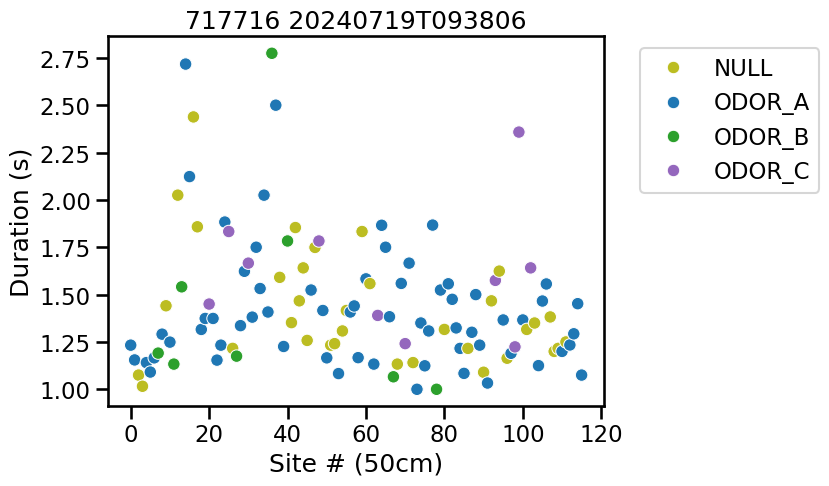

In [14]:
# plot duration of each reward site, with the trial type / odor_label in color
plot_duration_by_site(
    data=plot_df,
    x_col='active_patch',
    y_col='time_in_odor_site',
    hue_col='odor_label',
    hue_order=np.sort(plot_df['odor_label'].unique()),
    palette=odor_list_color,
    x_label='Site # (50cm)',
    y_label='Duration (s)',
    title=f'{mouse} {session}'
)

# Breathing Signal for a Site


In [15]:
#merge dictionaries for intersites and sites
label_dict = {**{
    "InterSite": '#808080',
    "InterPatch": '#b3b3b3'}, 
              **color_dict_label}


In [53]:
# identify peaks and troughs
def identify_peaks_and_troughs(data, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    """
    Identify peaks and troughs in the given data.
    
    Parameters:
    - data: The data array to analyze, typically used w sniff data.
    - width_peaks: Minimum width of peaks.
    - prominence_peaks: Minimum prominence of peaks.
    - width_troughs: Minimum width of troughs.
    - prominence_troughs: Minimum prominence of troughs.
    
    Returns:
    - peak_times: Timestamps of peaks.
    - trough_times: Timestamps of troughs.
    """
    # Clean up data (remove NaNs, duplicate indices, etc.)
    data = data.dropna()
    data = data[~data.index.duplicated(keep='first')]
    data = data.sort_index()

    # Convert to numpy array
    data_values = data.values.squeeze()

    # Find peaks
    peaks, _ = find_peaks(data_values, width=width_peaks, prominence=prominence_peaks)
    
    # Find troughs
    troughs, _ = find_peaks(-data_values, width=width_troughs, prominence=prominence_troughs)
    
    # Ensure troughs are below the corresponding peaks
    troughs = troughs[troughs > peaks[0]]  # First trough after the first peak

    # Get timestamps corresponding to the peaks and troughs
    peak_times = data.index[peaks]
    trough_times = data.index[troughs]

    return peak_times, trough_times


In [17]:
#function for aligning sniff peaks with rewards

def align_sniff_peaks_with_rewards(stream_data, reward_sites, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    """
    Align sniff peaks with reward sites and create a new DataFrame with aligned sniff peaks.

    Parameters:
    - stream_data (object): Data object containing sniff data with a 'breathing' attribute.
    - reward_sites (pd.DataFrame): DataFrame with reward sites and their start times.
    - width_peaks (int): Minimum width of peaks.
    - prominence_peaks (float): Minimum prominence of peaks.
    - width_troughs (int): Minimum width of troughs.
    - prominence_troughs (float): Minimum prominence of troughs.

    Returns:
    - pd.DataFrame: DataFrame with reward sites aligned to the first sniff peak.
    """

    # Create a copy of the reward_sites DataFrame and rename it to sniff_aligned
    sniff_aligned = reward_sites.copy()

    # Identify peaks and troughs in the sniff data
    peak_times, trough_times = identify_peaks_and_troughs(
        stream_data.breathing,
        width_peaks=5,
        prominence_peaks=0.1,
        width_troughs=3,
        prominence_troughs=0.1
    )

    # Initialize list for storing indices of the first peaks
    first_peaks = []
    
    # Iterate over each reward site
    for start_time in sniff_aligned.index:
        # Get the index of the first peak time after the start of the reward site
        first_peaks.append(np.searchsorted(peak_times, start_time))

    # Initialize list for storing new timestamps
    first_sniff_peak_start_time = []
    
    for first_peak in first_peaks:
        # Get the timestamp of the first sniff peak after the start of each reward site
        first_sniff_peak_start_time.append(peak_times[first_peak])

    # Create new DataFrame with the aligned sniff peaks
    sniff_aligned['first_sniff_peak'] = first_sniff_peak_start_time

    # Set 'first_sniff_peak' column as the index
    sniff_aligned = sniff_aligned.set_index('first_sniff_peak')
    sniff_aligned.index.name = 'times'

    return sniff_aligned

sniff_aligned = align_sniff_peaks_with_rewards(stream_data, reward_sites)

In [54]:
#make df for plotting breathing sniffs
trial_summary_breathing = plotting.trial_collection(sniff_aligned[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], stream_data.breathing, mouse, session, window=(-2,8), taken_col='data')

In [55]:
trial_summary_breathing

,times,data,has_choice,visit_number,odor_label,odor_sites,time_in_odor_site,mouse,session
0,-2.000,2186,False,0.0,ODOR_A,0.0,1.234016,717716,20240719T093806
1,-1.996,2188,False,0.0,ODOR_A,0.0,1.234016,717716,20240719T093806
2,-1.992,2218,False,0.0,ODOR_A,0.0,1.234016,717716,20240719T093806
3,-1.988,2221,False,0.0,ODOR_A,0.0,1.234016,717716,20240719T093806
4,-1.984,2215,False,0.0,ODOR_A,0.0,1.234016,717716,20240719T093806
...,...,...,...,...,...,...,...,...,...
287495,7.980,2259,False,0.0,ODOR_A,114.0,1.452992,717716,20240719T093806
287496,7.984,2261,False,0.0,ODOR_A,114.0,1.452992,717716,20240719T093806
287497,7.988,2248,False,0.0,ODOR_A,114.0,1.452992,717716,20240719T093806
287498,7.992,2268,False,0.0,ODOR_A,114.0,1.452992,717716,20240719T093806


In [56]:
def plot_sniff(total_site):
    align = None
    # Plot the signal
    fig, ax = plt.subplots(1,1, figsize= (8,6), sharex=True)
 
    color = color_dict_label[trial_summary_breathing.odor_label.unique()[0]]
    total_sites_df = trial_summary_breathing.loc[trial_summary_breathing.odor_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['data']
    max_signal = max(trial_summary_breathing.data.values)
    min_signal = min(trial_summary_breathing.data.values)


    # calculate the end time of the odor site and the new x-axis limits
    odor_end_time = total_sites_df.time_in_odor_site.unique()[0]
    x_start = -2
    x_end = odor_end_time + 0.5  # extend 1 second past the end time of the odor site
    
    # Plot the signal
    ax.plot(time, signal, color='black')
    ax.set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.odor_sites.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles = ':')

    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df['odor_offset'].unique(), color=color, alpha=.5, linewidth=0)
    else:
        # ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_onset'].unique(), 0, color=color, alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df.time_in_odor_site.unique()[0], color=color, alpha=.5, linewidth=0)

    # Set plot limits and labels
    ax.set_xlabel('Time (s)')
    ax.set_xlim(x_start, x_end) 
    sns.despine()
    plt.show()

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)
 

Output()

# Breathing

In [57]:
# breathing data 
breathing = stream_data.breathing

# # Clean up data (remove NaNs, duplicate indices, etc.)
breathing = breathing.dropna()
breathing = breathing[~breathing.index.duplicated(keep='first')]
breathing = breathing.sort_index()

breathing_data = breathing.values.squeeze()

# Find peaks in the breathing signal
peaks = find_peaks(breathing_data, width = 5,  prominence=0.1)[0]

# Find troughs in the breathing signal
troughs = find_peaks(-breathing_data, height=0, width=3, prominence=0.1)[0]

# Ensure troughs are below the corresponding peak
troughs = troughs[troughs > peaks[0]]  # first trough after the first peak


In [58]:
#check length of peaks and troughs
len(peaks), len(troughs)

(12310, 13114)

In [59]:
# get timestamps corresponding to the peaks and troughs
peak_times = breathing.index[peaks]
trough_times = breathing.index[troughs]

In [60]:
#function to plot peaks and troughs
def peak_plot(x_start=None, x_end=None, window_duration=10):
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # default to the entire range if no specific x_start or x_end is given
    if x_start is None:
        x_start = breathing.index.min()
    if x_end is None:
        x_end = breathing.index.max()
    
    # calculate the center of the window based on x_start and x_end
    center_time = (x_start + x_end) / 2

    # adjust the x_start and x_end to show a 10-second window
    x_start = max(center_time - window_duration / 2, breathing.index.min())
    x_end = min(center_time + window_duration / 2, breathing.index.max())
    ax.grid(True)

     # Plot the breathing data
    ax.plot(breathing.index, breathing_data, label='Breathing Signal', color='black', linewidth=1)

    # plot peaks
    ax.scatter(peak_times, breathing_data[peaks], color='red', marker='o', label='Peaks')

    # plot troughs
    ax.scatter(trough_times, breathing_data[troughs], color='blue', marker='x', label='Troughs')

    # Aad labels, title, and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Breathing Signal')
    ax.set_title(f'Breathing Signal with Peaks and Troughs for {mouse} {session}')
    ax.legend()
    ax.set_xlim([x_start, x_end])
    
    plt.show()

In [25]:
# define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 10
    x_end_widget.value -= 10

def on_right_button_clicked(button):
    x_start_widget.value += 10
    x_end_widget.value += 10

# create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# define widgets for the x-axis range
x_start_widget = widgets.FloatText(value=breathing.index.min(), description='X start:', continuous_update=False)
x_end_widget = widgets.FloatText(value=breathing.index.max(), description='X end:', continuous_update=False)

# set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# arrange the buttons and widgets horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget, x_end_widget])

# create interactive plot
interactive_plot = widgets.interactive_output(peak_plot, {'x_start': x_start_widget, 'x_end': x_end_widget})

In [26]:
#interactive plot
display(ui, interactive_plot)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x600 with 1 Axes>', '…

# Plot Breathing with Peaks, and Running overlayed

In [61]:
#plotting peaks and troughs with breathing signal
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [2, 2]}, sharex=True)

    # Plot event patches
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx + 1] - active_site.index[idx], 8,
            linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        axs[0].add_patch(p)

        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx + 1] - active_site.index[idx], 8,
            linewidth=0, facecolor=facecolor, alpha=0.5)
        _legend[site_label] = q
        axs[1].add_patch(q)

    s, lw = 400, 2

    # Plot Choice Tone, Lick, and Reward
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index + 0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index * 0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")

    y_idx += 1

    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top=3)
    axs[1].grid(False)

    # Breathing plot with peaks and troughs
    ax3 = axs[0].twinx()
    breathing_data = stream_data.breathing.values.squeeze()
    peaks = find_peaks(breathing_data, width=5, prominence=0.1)[0]
    troughs = find_peaks(-breathing_data, height=0, width=3, prominence=0.1)[0]
    troughs = troughs[troughs > peaks[0]]  # Filter out invalid troughs

    peak_times = stream_data.breathing.index[peaks]
    trough_times = stream_data.breathing.index[troughs]

    _legend["Breathing"] = ax3.plot(stream_data.breathing.index - zero_index, breathing_data, c="black", label="Breathing", alpha=0.8)[0]
    ax3.scatter(peak_times - zero_index, breathing_data[peaks], color='red', marker='o', label='Peaks')
    ax3.scatter(trough_times - zero_index, breathing_data[troughs], color='blue', marker='x', label='Troughs')

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0] - 400, stream_data.breathing.mean()[0] + 400)
    ax3.set_ylabel("Breathing (au)")

    # Plot velocity (running data) on the bottom subplot
    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha=0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha=0.5, lw=2, ls="--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.08, 0.1), loc='center left', borderaxespad=0.)

    for i in [0, 1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top=4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 5])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 5

def on_right_button_clicked(button):
    x_start_widget.value += 5

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

# trying to get peaks and troughs for each odor site

In [62]:
#identify peaks and troughs
peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1)


In [63]:
# Update the plot_sniff functionn to include peaks and troughs
def plot_sniff(total_site):
    align = None
    # Prepare figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
    
    # Select data for the given total_site
    total_sites_df = trial_summary_breathing.loc[trial_summary_breathing.odor_sites == total_site]
    
    # Calculate the end time of the odor site and the new x-axis limits
    odor_end_time = total_sites_df.time_in_odor_site.unique()[0]
    x_start = -2
    x_end = odor_end_time + 0.5  # Extend 0.5 seconds past the end time of the odor site

    # Get relevant data
    time = total_sites_df['times']
    signal = total_sites_df['data']
    odor_label = total_sites_df.odor_label.unique()[0]
    odor_color = color_dict_label.get(odor_label, 'gray')  # Default to gray if label not found
    max_signal = max(trial_summary_breathing.data.values)
    min_signal = min(trial_summary_breathing.data.values)

    # identify peaks and troughs in the signal data
    peak_times, trough_times = identify_peaks_and_troughs(total_sites_df.set_index('times')['data'])

    # Plot the signal
    ax.plot(time, signal, color='black', label='Signal')
    ax.set_title(f'Odor: {odor_label}  Odor site: {total_sites_df.odor_sites.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles=':')

    # Shade the region based on odor label
    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal, max_signal, 0.1),
                         0, total_sites_df['odor_offset'].unique(),
                         color=odor_color, alpha=.5, linewidth=0)
    else:
        ax.fill_betweenx(np.arange(min_signal, max_signal, 0.1),
                         0, total_sites_df.time_in_odor_site.unique()[0],
                         color=odor_color, alpha=.5, linewidth=0)

    # Plot peaks and troughs
    ax.scatter(peak_times, total_sites_df.set_index('times')['data'].loc[peak_times], color='red', marker='o', label='Peaks')
    ax.scatter(trough_times, total_sites_df.set_index('times')['data'].loc[trough_times], color='blue', marker='x', label='Troughs')

    # Set plot limits and labels
    ax.set_xlabel('Time (s)')
    ax.set_xlim(x_start, x_end) 
    ax.legend()
    sns.despine()
    plt.show()

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=0.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


Output()

# instantaneous sniff rate

# average peaks per odor site

# velocity traces for session

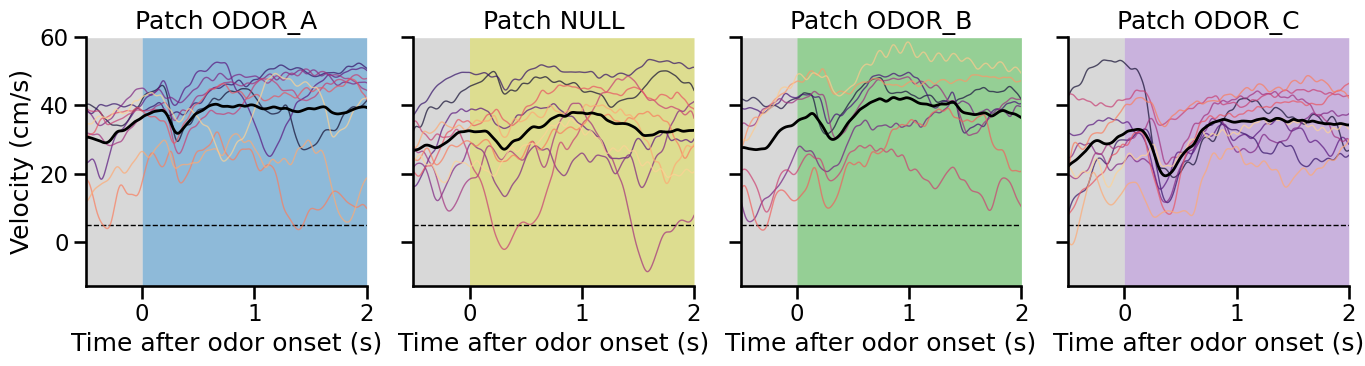

In [30]:
#plot velocity trace for one animal, first 10 sites
trial_summary_running= plotting.trial_collection(reward_sites[[ 'visit_number', 'odor_label','odor_sites']], encoder_data, mouse, session, window=(-2,4))
trial_summary_running.loc[(trial_summary_running.odor_label == 'NULL')].odor_sites.unique()
max_range=max(trial_summary_running.speed.values)
plotting.velocity_traces_odor_entry(trial_summary_running, 
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False)

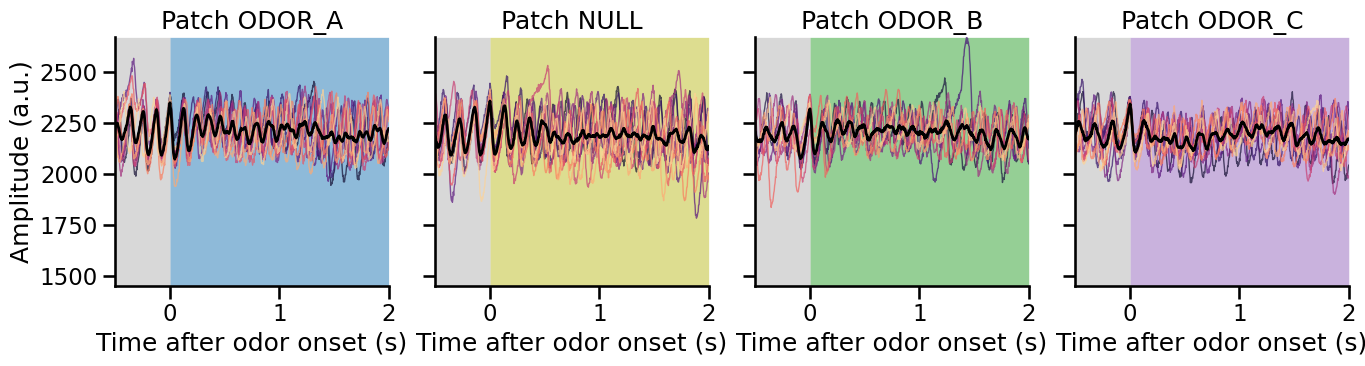

In [31]:
#make df for plotting breathing sniffs
trial_summary_breathing.loc[(trial_summary_breathing.odor_label == 'NULL')].odor_sites.unique()
y_max = trial_summary_breathing.data.max()
y_min = trial_summary_breathing.data.min()
plotting.velocity_traces_odor_entry(trial_summary_breathing, y_lims = (y_min, y_max),
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False,  y = 'data', n_sites = 10, y_label='Amplitude (a.u.)')

### get sniff peak times rasterplot

In [32]:
#make df for plotting breathing sniffs
trial_summary_breathing = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], stream_data.breathing, mouse, session, window=(-2,8), taken_col='data')

In [38]:
#reset index and get peak indices
tmp = stream_data.breathing.reset_index()
peak_time_indices = tmp[tmp['Time'].isin(peak_times)].index.values

In [39]:
#create peak timeseries
sniff_timestamps = stream_data.breathing.index
peaks_timeseries = np.zeros(len(sniff_timestamps))
peaks_timeseries[peak_time_indices] = 1
print(len(sniff_timestamps), len(peaks_timeseries)), len(peak_time_indices)


529472 529472


(None, 12310)

In [40]:
type(peak_time_indices)

numpy.ndarray

In [41]:
#convert timeseries to df
peaks_df = pd.DataFrame(index=stream_data.breathing.index, data=peaks_timeseries, columns=['peaks'])
# peaks_df.head()


### get odor aligned inter sniff interval

In [42]:
#filter peaks and compute ISI
isi_df = peaks_df[peaks_df['peaks']==1]
isi_df = isi_df.reset_index()
isi_df['isi'] = isi_df['Time'].rolling(window=2).apply(np.diff)
isi_df = isi_df.dropna(subset=['isi'])
isi_df.head()
isi_df = isi_df.set_index('Time')
print(isi_df)


              peaks       isi
Time                         
9.413731e+06    1.0  0.128000
9.413731e+06    1.0  0.139968
9.413731e+06    1.0  0.124000
9.413731e+06    1.0  0.124000
9.413731e+06    1.0  0.132000
...             ...       ...
9.415848e+06    1.0  0.104000
9.415848e+06    1.0  0.124000
9.415848e+06    1.0  0.112000
9.415848e+06    1.0  0.112000
9.415849e+06    1.0  0.136000

[12309 rows x 2 columns]


In [46]:
peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1)


In [45]:
#plotting ISI
plotting.velocity_traces_odor_entry(trial_summary_isi,
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False,  y = 'isi', n_sites = 5)

NameError: name 'trial_summary_isi' is not defined

In [ ]:
#calculate isi
isi = np.diff(peak_times) 
len(isi), len(peak_times)

(12309, 12310)

In [ ]:
#intersniff interval trial summary
trial_summary_isi= plotting.trial_collection(reward_sites[[ 'visit_number', 'odor_label','odor_sites']], isi_df, mouse, session, window=(-2,4), taken_col='isi')

In [ ]:
trial_summary_isi

,times,isi,visit_number,odor_label,odor_sites,mouse,session
0,-2.000,0.132000,0.0,ODOR_A,0.0,717716,20240719T093806
1,-1.828,0.120000,0.0,ODOR_A,0.0,717716,20240719T093806
2,-1.656,0.127968,0.0,ODOR_A,0.0,717716,20240719T093806
3,-1.484,0.128000,0.0,ODOR_A,0.0,717716,20240719T093806
4,-1.312,0.128000,0.0,ODOR_A,0.0,717716,20240719T093806
...,...,...,...,...,...,...,...
4019,3.160,0.260000,0.0,ODOR_A,114.0,717716,20240719T093806
4020,3.332,0.184000,0.0,ODOR_A,114.0,717716,20240719T093806
4021,3.504,0.192032,0.0,ODOR_A,114.0,717716,20240719T093806
4022,3.676,0.183968,0.0,ODOR_A,114.0,717716,20240719T093806


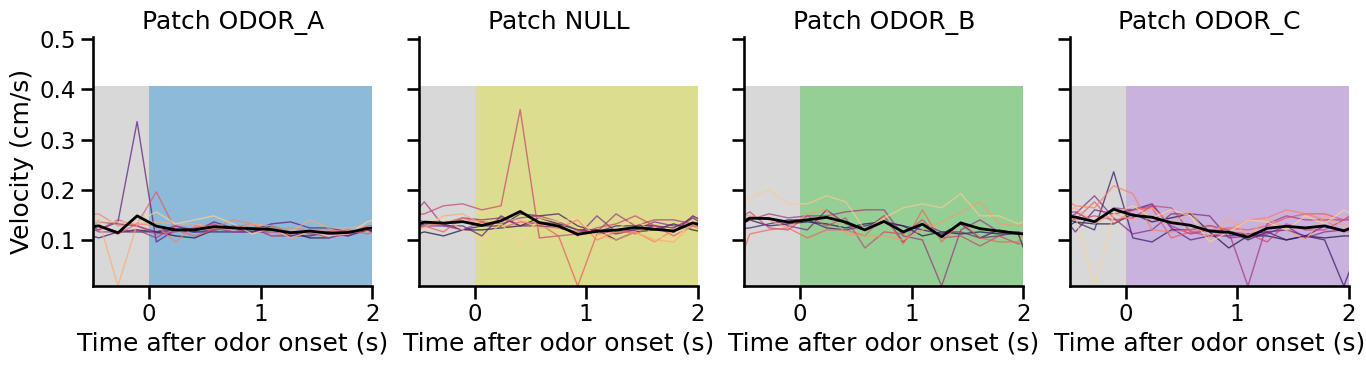

In [ ]:
trial_summary_isi.loc[(trial_summary_isi.odor_label == 'NULL')].odor_sites.unique()
y_max = trial_summary_isi.isi.max()
y_min = trial_summary_isi.isi.min()
plotting.velocity_traces_odor_entry(trial_summary_isi, y_lims = (y_min, y_max),
                                    color_dict_label=color_dict_label, cmap = 'magma', 
                                    mean=True, save=False,  y = 'isi', n_sites = 10)

In [ ]:
#same one for sniffing
#align to first peak for first 10 odor sites
#subtract odor onset time from peak times -- will always start at 0